In [1]:
import pysam
import collections
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

**User Edit the following cell:**

In [2]:
# folder containing the bamfiles
bam_folder = './spikein_from_bob/'

# folder to write output files to
output_folder = './results'

# enter the input and cmc files
# make sure to order them in correct paired order
input_files = ['HG_input_filtered.bam','HG_FA_input_filtered.bam','LG_input_filtered.bam','LG_FA_input_filtered.bam']
cmc_files = ['HG_CMC_filtered.bam','HG_FA_CMC_filtered.bam','LG_CMC_filtered.bam','LG_FA_CMC_filtered.bam']
# names for each experiment in same order as files
exp_names = ['HG', 'HG_FA', 'LG', 'LG_FA']

# window size for calculating peak values by Carlile method
window_size = 20 

# set to True if want to add +1 pseudocount for each position
pseudocount = True

# file containing known sites
# set as '' if don't want to include known sites
known_sites_file = 'Carlile_known_human_SuppT7_updated.csv'

In [3]:
end_counts_folder = os.path.join(output_folder, 'end_counts')
plots_folder = os.path.join(output_folder, 'plots')

# check if ouput folder already exists
if os.path.isdir(output_folder):
    print(f'Warning: {output_folder} already exists - any same name files will be overwritten')
else: # create dir if it doesn't exist
    os.mkdir(output_folder)
    os.mkdir(end_counts_folder)
    os.mkdir(plots_folder)

In [83]:
# get the full filenames including path
bamfiles = [os.path.join(bam_folder, bamfile) for bamfile in input_files + cmc_files]

# get just the sample name from the filename
input_samples = [file.split('.')[0] for file in input_files]
cmc_samples = [file.split('.')[0] for file in cmc_files]
samples = input_samples + cmc_samples

exp_peaks = [f'{i}_Peak_ws{window_size}' for i in exp_names]
exp_input_peaks = [f'{i}_Input_Peak_ws{window_size}' for i in exp_names]

In [5]:
# get the reference names from a bam file
samfile = pysam.AlignmentFile(bamfiles[0], 'rb')
ref_names = samfile.references

# make a dict to convert the long name to a short abbreviation (if aligned to rRNA)
rrnas = ('5-8S','18S','28S')
ref_name_to_abbrev = {}
for ref_name in ref_names:
    found_rrnas = [rrna for rrna in rrnas if rrna in ref_name]
    if len(found_rrnas) > 1:
        raise SystemError(f'Found multiple rRNA names in {ref_name}')
    if not found_rrnas:
        print(f'Warning: did not find expected rRNA name in {ref_name}')
        ref_name_to_abbrev[ref_name] = ref_name
    else:
        ref_name_to_abbrev[ref_name] = found_rrnas[0]

# ref_names will be 5-8S, 18S, 28S if aligned only to rRNA
ref_names = ref_name_to_abbrev.values()

In [6]:
# read in known Psi sites from Bob's updating of Carlile supplementary table 7
# Bob's positions are in the 'NCBI tx pos' column
# store them in abbrev_ref_to_known {abbrev_ref: [list of known sites]}
rrna_to_known = {}

if known_sites_file:
    known_df = pd.read_csv(known_sites_file)
    
    for rrna in rrnas:
        vals = known_df[known_df['gene name'].str.contains(rrna)]['NCBI tx pos'].values
        rrna_to_known[rrna] = vals

In [7]:
def get_end_count(bamfile, ref_name_to_abbrev):
    '''
    Given a bamfile
    Gets 5' R1 end counts
    Returns 2 nested dicts with keys=[ref_name][pos]
    one will have the counts at each pos, 
    the other has the ref_base at each pos
    '''
    samfile = pysam.AlignmentFile(bamfile, 'rb')
    reads = samfile.fetch()
    
    counts = {}
    bases = {}
    
    for read in reads:
        if read.is_read1 and not read.is_reverse:
            ref = ref_name_to_abbrev[read.reference_name]
            pos = read.reference_start + 1 # Read 1, 5-prime (add 1 since pysam 0-based)
            base = read.get_reference_sequence()[0].upper()
            if ref not in counts:
                counts[ref] = collections.defaultdict(int)
                bases[ref] = {}

            counts[ref][pos] += 1
            if pos in bases[ref] and bases[ref][pos] != base:
                raise SystemError(f'Different bases found at position {pos}: current={base} previous={bases[ref][pos]}')
            bases[ref][pos] = base
    
    return counts, bases

In [8]:
# if already csv files in output_folder/end_counts then read those in to dataframe
if glob.glob(end_counts_folder + '/*.csv'):
    print(f'csv files already exist in {end_counts_folder}')
    print('Reading in those csv files to pandas dataframe')
    
    ref_df = {}
    for csv_file in glob.glob(end_counts_folder + '/*.csv'):
        print(f'Read in {csv_file}')
        ref_name = os.path.basename(csv_file)
        df = pd.read_csv(csv_file, index_col=0)
        ref_df[ref_name.split('.')[0]] = df
        
else:
    # get 5' R1 end counts, along with corresponding bases for each sample
    counts = {}
    bases = {}
    for sample, bamfile in zip(samples, bamfiles):
        print(f'Getting counts from {sample}...')
        counts[sample], bases[sample] = get_end_count(bamfile, ref_name_to_abbrev)

    # convert to a pandas dataframe (one for each ref_name)
    ref_df = {}
    for ref_name in ref_names:
        # get the counts from each sample for that ref_name
        # also find the maximum pos across all samples
        d = {}
        combined_bases = {}
        max_pos = -1
        for sample in samples:
            d[sample] = counts[sample][ref_name]
            combined_bases.update(bases[sample][ref_name])
            max_pos = max(max_pos, max(d[sample]))

        # find any positions that got zero reads in all samples
        # assign one sample to have a 0 there, and the rest of
        # the sample will get filled in with NaN and then 0 later
        for i in range(1,max_pos+1):
            if i not in combined_bases:
                d[sample][i] = 0 # just assign it to one of the samples
                combined_bases[i] = '-'

        df = pd.DataFrame.from_dict(d)
        df = df.fillna(0) # replace NaN with 0 for positions that had no counts

        if pseudocount: # add 1 pseudocount for each position
            df += 1

        df['Sequence'] = pd.Series(combined_bases) # add column for bases

        # put columns in order of input samples, cmc samples, sequence
        df = df[samples + ['Sequence']]

        # put in dict where key = ref_name
        ref_df[ref_name] = df

csv files already exist in ./results/end_counts
Reading in those csv files to pandas dataframe
Read in ./results/end_counts/18S.csv
Read in ./results/end_counts/28S.csv
Read in ./results/end_counts/5-8S.csv


In [9]:
def coverage_plots(df, input_samples, cmc_samples, ref_name, output_folder):
    '''
    Given dataframe, input and cmc samples
    Make plot how end counts per nucleotide for each gene
    '''
    
    fig, axes = plt.subplots(figsize=(18,len(samples)*3),nrows=len(input_samples), ncols=2)
    for row, (input_sample, cmc_sample) in enumerate(zip(input_samples, cmc_samples)):
        for col, sample in enumerate((input_sample, cmc_sample)):
            counts = df[sample].values
            ax = axes[row,col]
            ax.plot(range(len(counts)), counts)
            #ax.hist(counts)
            ax.set_title(f'{ref_name} {sample}')
            ax.text(.02,.90,f'mean counts per position: {int(np.mean(counts))}',fontsize=18,
                    transform=ax.transAxes)
            ax.set_xlabel('position in gene')
            ax.set_ylabel('end counts')
    png_title = os.path.join(output_folder, f'{ref_name}_end_count_coverage.png')
    fig.savefig(png_title)
    print(f'{png_title} was saved')
    plt.close(fig)

In [10]:
for ref_name, df, in ref_df.items():
    coverage_plots(df, input_samples, cmc_samples, ref_name, plots_folder)

./results/plots/18S_end_count_coverage.png was saved
./results/plots/28S_end_count_coverage.png was saved
./results/plots/5-8S_end_count_coverage.png was saved


In [11]:
def scale_input(ref_df, input_name, cmc_name, exp_name):
    '''
    Given: dictionary {ref_name: df}, and a pair of input/cmc names
    Scale input to be same total reads as cmc for each input/cmc pair
    df is modified in-place in function (don't need to return it)
    New columns '_scaled' are added
    '''
    # get total reads for input and CMC over all refs
    cmc_total = input_total = 0
    for df in ref_df.values():
        cmc_total += df[cmc_name].sum()
        input_total += df[input_name].sum()

    ratio = cmc_total / input_total

    # multiply the input reads times the cmc/input ratio
    for df in ref_df.values():  # for each reference gene
        scaled_input = df[input_name].copy()
        scaled_input *= ratio
        df[input_name + '_scaled'] = pd.Series(scaled_input)

    print(f'{exp_name}\t{int(input_total):<8}\t{int(cmc_total):<8}\t{ratio:.4f}')

In [12]:
# scale the input counts for each input/cmc pair
print(f'Exp.\tInput_total\tCMC_total\tCMC/Input_ratio')
for exp_name, input_name, cmc_name in zip(exp_names, input_samples, cmc_samples):
    scale_input(ref_df, input_name, cmc_name, exp_name)  

Exp.	Input_total	CMC_total	CMC/Input_ratio
HG	92139   	122254  	1.3268
HG_FA	94970   	100065  	1.0536
LG	96404   	119069  	1.2351
LG_FA	148995  	116494  	0.7819


In [13]:
def get_peak_value(cmc_vals, inp_vals, pos, ws, input_peak=False, verbose=False):
    '''
    Given: series of end counts for cmc/input pair and 
    a position and window-size
    Calculates peak value by looking at the end counts at 
    the 3' base (+1 from given position)
    If input_peak set to True, it will calculate the -CMC peak value from Carlile
    Returns: peak value
    '''
    pos += 1 # look at 3' base where termination should pile up
    
    if pos > len(cmc_vals): # can't do last base since nothing is 3'
        return np.nan

    r_cmc = cmc_vals.loc[pos]
    r_inp = inp_vals.loc[pos]
    
    # for example if want to look at position 5 with ws=4
    # windows will include positions (3,4,5,6,7)
    lo_pos = max(1, pos - int(ws/2))
    hi_pos = pos + int(ws/2)
    
    wr_cmc = cmc_vals.loc[lo_pos:hi_pos].sum() - r_cmc
    wr_inp = inp_vals.loc[lo_pos:hi_pos].sum() - r_inp

    if (wr_cmc + wr_inp) == 0:
        return np.nan
    
    if input_peak:
        peak = ws * r_inp / (wr_cmc + wr_inp)
    else:
        peak = ws * (r_cmc - r_inp) / (wr_cmc + wr_inp)
        
    if verbose:
        print(f'3-prime position to look at: {pos}')
        print(f'cmc reads at pos {pos}: {r_cmc}')
        print(f'input reads at pos {pos}: {r_inp}')
        print(f'pos: {pos}, lo_pos: {lo_pos}, hi_pos: {hi_pos}')
        print(cmc_vals.loc[lo_pos:hi_pos])
        print(inp_vals.loc[lo_pos:hi_pos])
        print(f'peak: {peak}')
    return peak

In [84]:
# calculate peak values for each input/cmc pair
# also keep track of min_peak and max_peak overall
min_peak, max_peak = 1e9, -1e9
for exp_peak, exp_input_peak, input_name, cmc_name in zip(exp_peaks, exp_input_peaks, input_samples, cmc_samples):
    print(exp_peak)
    for ref_name, df in ref_df.items(): # for each reference gene
        print('> ' + ref_name)
        peaks = []
        input_peaks = []
        for pos in df.index: # for each position
            peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, window_size))
            input_peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, 
                                              window_size, input_peak=True))            
        df[exp_peak] = peaks
        df[exp_input_peak] = input_peaks
        
        min_peak = min(min_peak, df[exp_peak].min())
        max_peak = max(max_peak, df[exp_peak].max())

print(f'min peak = {min_peak}')
print(f'max peak = {max_peak}')
        
# save df as csv for each reference gene
for ref_name, df in ref_df.items(): 
    # next line is to make sure cols are in right order
    df = df[samples + ['Sequence'] + [i+'_scaled' for i in input_samples] + exp_peaks]
    output_name = os.path.join(end_counts_folder, f'{ref_name}.csv')
    df.to_csv(output_name)
    print(f'{output_name} file was saved')

HG_Peak_ws20
> 18S
> 28S
> 5-8S
HG_FA_Peak_ws20
> 18S
> 28S
> 5-8S
LG_Peak_ws20
> 18S
> 28S
> 5-8S
LG_FA_Peak_ws20
> 18S
> 28S
> 5-8S
min peak = -17.884365097398195
max peak = 54.91668117203364
./results/end_counts/18S.csv file was saved
./results/end_counts/28S.csv file was saved
./results/end_counts/5-8S.csv file was saved


In [85]:
ref_df['5-8S'].columns

Index(['HG_input_filtered', 'HG_FA_input_filtered', 'LG_input_filtered',
       'LG_FA_input_filtered', 'HG_CMC_filtered', 'HG_FA_CMC_filtered',
       'LG_CMC_filtered', 'LG_FA_CMC_filtered', 'Sequence',
       'HG_input_filtered_scaled', 'HG_FA_input_filtered_scaled',
       'LG_input_filtered_scaled', 'LG_FA_input_filtered_scaled',
       'HG_Peak_ws20', 'HG_FA_Peak_ws20', 'LG_Peak_ws20', 'LG_FA_Peak_ws20',
       'HG_Input_Peak_ws20', 'HG_FA_Input_Peak_ws20', 'LG_Input_Peak_ws20',
       'LG_FA_Input_Peak_ws20'],
      dtype='object')

In [31]:
rrna_to_known['18S']

array([  34,   36,   93,  105,  109,  119,  210,  218,  406,  572,  609,
        649,  651,  681,  686,  801,  814,  815,  822,  863,  866,  918,
        966, 1004, 1056, 1081, 1174, 1177, 1238, 1244, 1445, 1625, 1643,
       1692])

In [66]:
data = [(1,2),(3,4),(10,1)]
for i in zip(*data):
    print(i)

(1, 3, 10)
(2, 4, 1)


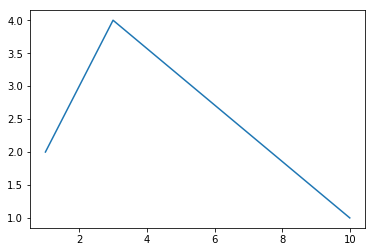

In [65]:
fig, ax = plt.subplots()
data = [(1,2),(3,4),(10,1)]
ax.plot(*zip(*data))

In [105]:
3000%1000

0

In [135]:
def roc(ref_df, exp_name, exp_peak, exp_input_peak, min_peak, max_peak, rrna_to_known, steps=10000):
    
    fig, ax = plt.subplots()
    i = 0
    for exp_peak_name, exp_peak_type in zip((exp_peak, exp_input_peak), ('+CMC', '-CMC')):
        data = []
        for peak in np.linspace(min_peak, max_peak, steps):
            i += 1
            if not i%(steps/5):
                print(f'{i/steps*50:.0f}%')
            #print(f'peak = {peak}')
            tp = p = fp = n = 0
            for ref_name, df in ref_df.items():
                known_sites = rrna_to_known[ref_name]
                df_known = df.loc[known_sites]
                tp += len(df_known[df_known[exp_peak_name]>=peak])
                p += len(known_sites)
                fp += len(df[df[exp_peak_name]>=peak]) - tp
                n += df.index.max() - p
    #             print(f'tp = {tp}')
    #             print(f'p = {p}')
    #             print(f'fp = {fp}')
    #             print(f'n = {n}')
            tpr = tp/p
            fpr = fp/n
    #         print(f'tpr = {tpr}')
    #         print(f'fpr = {fpr}')
            data.append((fpr, tpr))
        ax.plot(*zip(*data),label=exp_peak_type)
    ax.legend()
    ax.set_title(f'{exp_name} ROC testing peak cutoff using {steps} steps')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    filename = os.path.join(output_folder, f'{exp_name}_ROC_{steps}_steps.png')
    fig.savefig(filename)
    print(f'{filename} was saved...')

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
./results/HG_ROC_100_steps.png was saved...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
./results/HG_FA_ROC_100_steps.png was saved...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
./results/LG_ROC_100_steps.png was saved...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
./results/LG_FA_ROC_100_steps.png was saved...


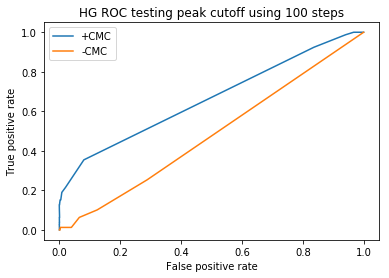

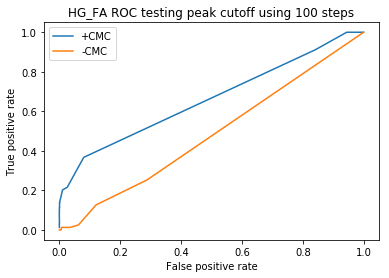

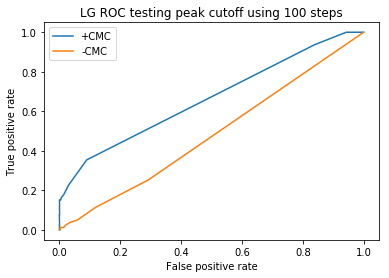

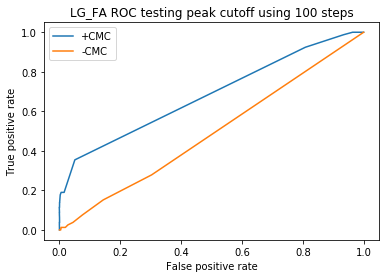

In [136]:
for exp_name, exp_peak, exp_input_peak in zip(exp_names, exp_peaks, exp_input_peaks):
    roc(ref_df, exp_name, exp_peak, exp_input_peak, min_peak, max_peak, rrna_to_known, steps=100)

In [119]:
min_peak = 1e9
max_peak = -1e9
for ref_name, df in ref_df.items():
    for exp_peak in exp_peaks:
        max_peak = max(max_peak, df[exp_peak].max())
        min_peak = min(min_peak, df[exp_peak].min())

print(min_peak, max_peak)        
for peak in np.linspace(min_peak, max_peak, 10):
    print(peak)


-17.8843650974 54.916681172
-17.8843650974
-9.79535995635
-1.7063548153
6.38265032575
14.4716554668
22.5606606078
30.6496657489
38.7386708899
46.827676031
54.916681172


In [53]:
df = ref_df['18S']
known_18S = rrna_to_known['18S']
known_18S
exp_peak = exp_peaks[0]
print(exp_peak)
df_known = df.loc[known_18S]
tp = len(df_known[df_known[exp_peak]>5])
print(tp)
p = len(known_18S)
print(p) # TP + FN = positives
fp = p - tp
n = df.index.max()-p
tpr = tp/p
fpr = fp/n
print(n)
print(tpr, fpr)

HG_Peak_ws20
5
34
1810
0.14705882352941177 0.0160220994475


In [24]:
ref_df['5-8S']['HG_Peak_ws20'].min()

-6.4876263317322254

In [36]:
def peak_plots(df, exp_peaks, ref_name, known_sites, ws, output_folder, show_plot=False):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    output_folder: where plots saved
    show_plot: set to False to hide plots in notebook (they will still be saved)
    Plots peak values for each position for all experiments in same plots
    '''  
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    fig, ax = plt.subplots(figsize=(24,8))
    for zorder, (d, color, style, label) in enumerate(cats):
        for exp_peak in exp_peaks:
            x_vals = d.index
            y_vals = d[exp_peak]
            ax.plot(x_vals, y_vals, style, color=color, label = label, zorder = zorder)
            label = ''
    ax.set_title(f'{ref_name} ws{ws}', fontsize=20)
    ax.set_ylabel('Peak value (Carlile method)',fontsize=14)
    ax.set_xlabel('nt position in gene',fontsize=14)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
    fig.subplots_adjust(right=0.8)
    filename = os.path.join(output_folder, f'{ref_name}_peaks_plot.png')
    fig.savefig(filename)
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

./results/plots/18S_peaks_plot.png was saved...
./results/plots/28S_peaks_plot.png was saved...
./results/plots/5-8S_peaks_plot.png was saved...


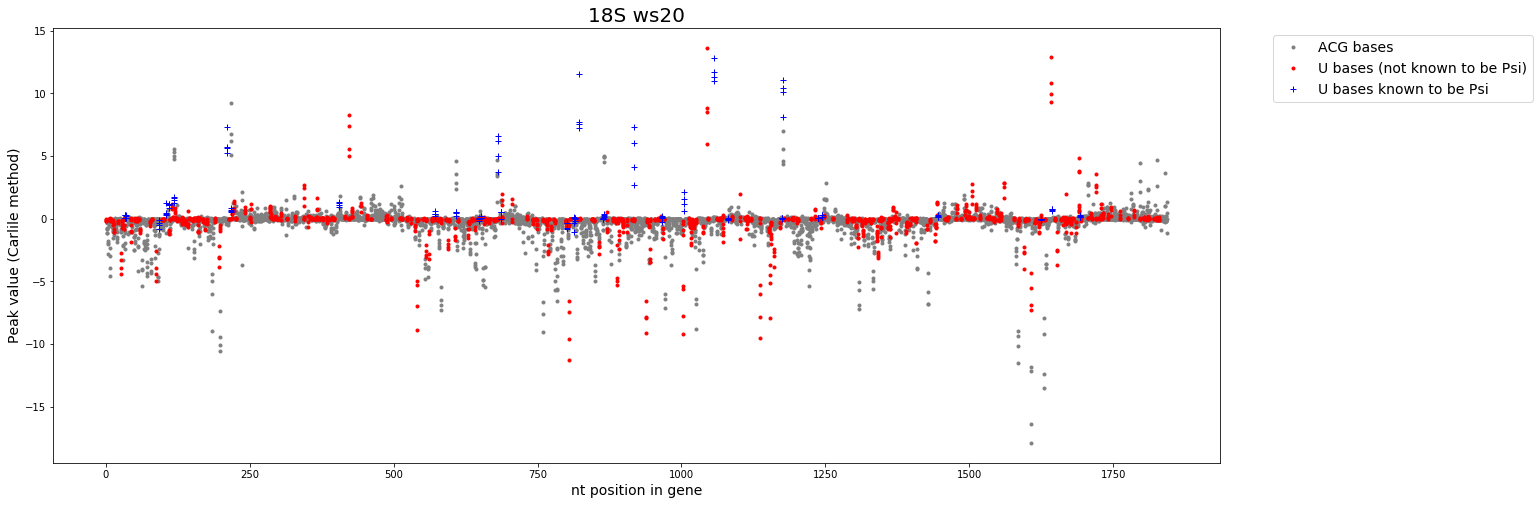

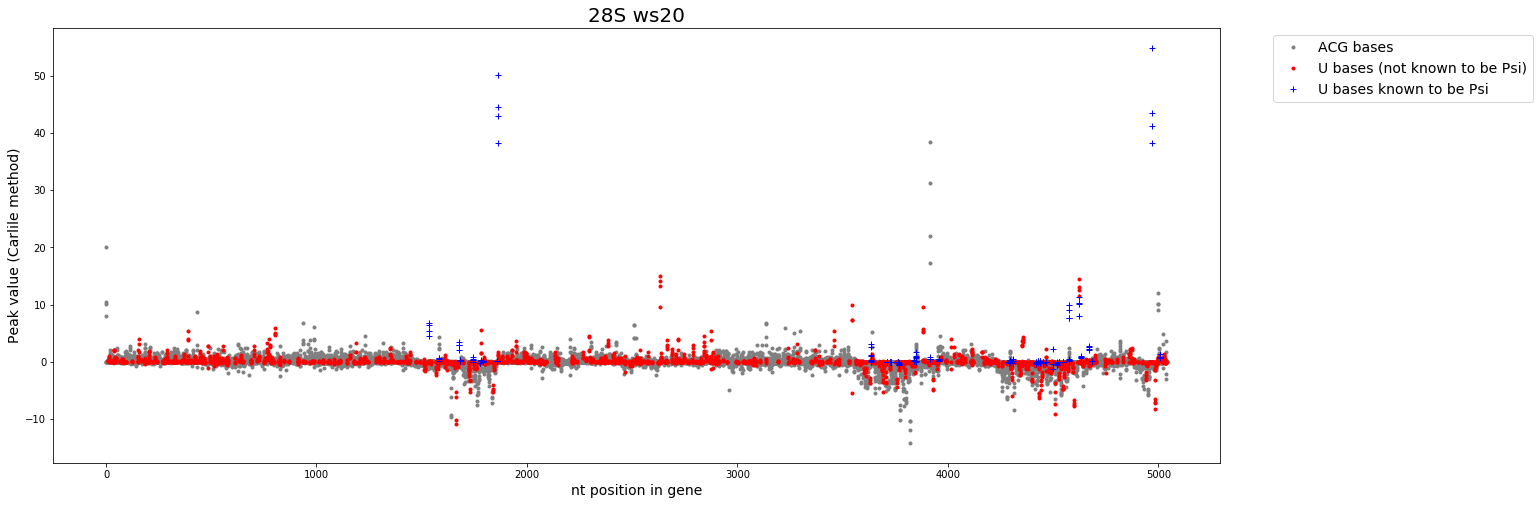

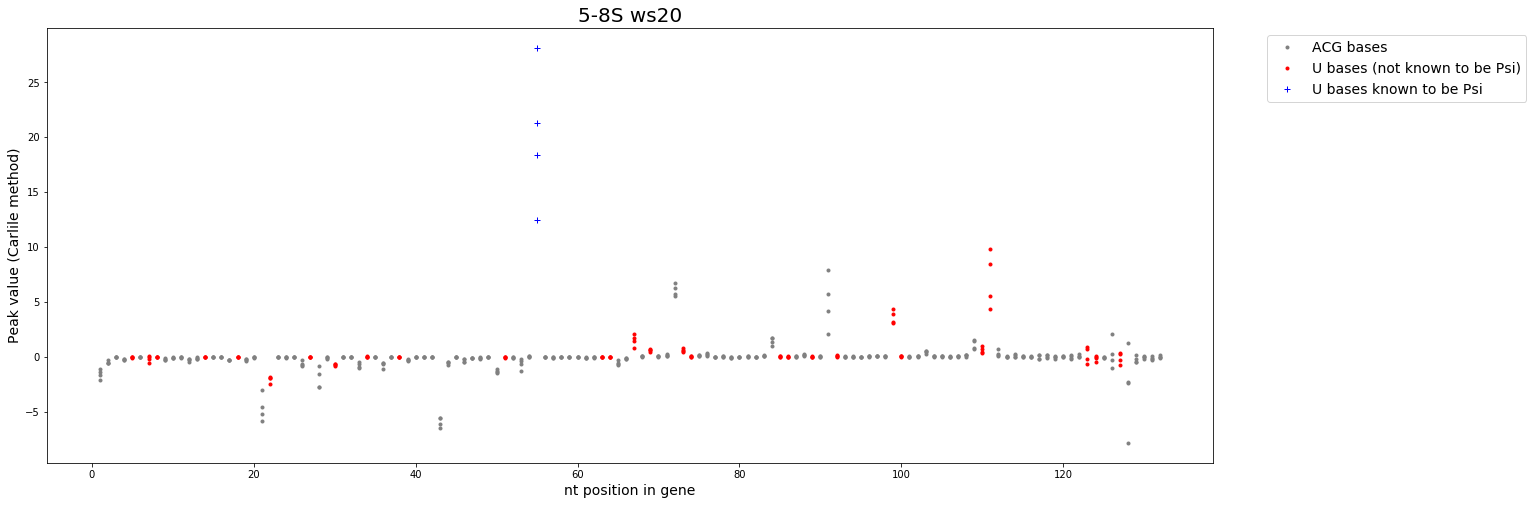

In [37]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    peak_plots(df, exp_peaks, ref_name, known_sites, window_size, plots_folder, show_plot=True)

In [36]:
def _plot_line(ax, x1, y1, x2, y2):
    '''
    Helper function for compare_exps to plot lines
    '''
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot((x1,x2),(y1,y2),'--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [37]:
def _center_ylim(ax):
    '''
    Helper function for compare_exps to adjust ylim
    '''
    max_ylim = max([abs(i) for i in ax.get_ylim()])
    ax.set_ylim(-max_ylim, max_ylim)

In [38]:
def compare_exps(df, exp_peaks, ref_name, known_sites, ws, output_folder, 
                 by_position=True, cutoff=None, log_scale=None, show_plot=True):
    '''
    Given:
    d: dataframe for a particular ref gene
    exp_peaks: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    output_folder: folder to save plots to
    by_position: if True plot expA-expB for each nt position, else plot scatter of expA vs expB
    cutoff: if True only include positions with peak >= cutoff under ALL experiments
    log_scale: take log of peak values, for example can use np.log2, np.log10, np.log
    show_plot: if False do not show plots in notebook (they will still be saved to output_folder)
    
    Make plots comparing each pair of experiments
    '''
    if cutoff is not None:
        df = df[(df[exp_peaks]>cutoff).all(axis='columns')]
        # apply cutoff to ALL experiments at that position
        # alternative is to just apply to each pair of experiments
        
        # need to get rid of known_sites that didn't pass cutoff
        # otherwise pandas generates a warning when try to use .loc
        known_sites = [site for site in known_sites if site in df.index]
        
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    nrows = ncols = len(exp_peaks) + 1
    
    fig, axes = plt.subplots(figsize=(12,12),nrows=nrows,ncols=ncols,sharex=True,sharey=True)
    
    min_val = 0 # keep track of min value so lower left will be on y=x if by_position is False
    
    for row, exp_a in enumerate(exp_peaks):
        # label the rows
        axes[row+1,0].text(0.5, 0.5, exp_a.split('_Peak')[0] + '\n'+ ref_name, 
                           transform=axes[row+1,0].transAxes, fontsize=16,
                           ha='center',va='center')
        
        for col, exp_b in enumerate(exp_peaks):
            if row == 0: # label the columns
                axes[row, col+1].text(0.5, 0.5, exp_b.split('_Peak')[0] + '\n'+ ref_name, 
                                      transform=axes[row,col+1].transAxes, fontsize=16,
                                      ha='center',va='center')
            if row == col: # don't plot same sample verse itself
                continue

            for zorder, (d, color, style, label) in enumerate(cats):
                a_vals, b_vals = d[exp_a], d[exp_b]
                if log_scale:
                    a_vals, b_vals = log_scale(a_vals), log_scale(b_vals)
         
                if by_position:
                    x_vals = d.index # x axis if nt position in gene
                    y_vals = (a_vals - b_vals)/np.sqrt(2) # sqrt(2) to get distance to y=x diagonal
                else:
                    x_vals, y_vals = b_vals, a_vals # plot a vs b
                    min_val = min(min(x_vals), min(y_vals), min_val)

                ax = axes[row+1,col+1]
                ax.plot(x_vals, y_vals, style, color=color, label=label, zorder=zorder)

    # loop thru again to plot lines and adjust axes limits
    for row, exp_a in enumerate(exp_peaks):
        for col, exp_b in enumerate(exp_peaks):
            if row == col:
                continue
            ax = axes[row+1, col+1]
            
            if by_position: 
                _center_ylim(ax) # center so that 0 is in middle of y-axis
                _plot_line(ax, -1000,0,10000,0) # plot horizontal y=0 line
                ax.set_xlim(-.1*df.index.max(),df.index.max()+.1*df.index.max())
                # add extra padding to left and right when setting xlim
                
                a_name = exp_a.split('_Peak')[0]
                b_name = exp_b.split('_Peak')[0]
                ax.text(.02,.90,f'{a_name} > {b_name}',fontsize=14,transform=ax.transAxes)
                ax.text(.02,.05,f'{b_name} > {a_name}',fontsize=14,transform=ax.transAxes)
            else:
                _plot_line(ax, -100,-100,100,100) # plot y=x diagonal
                ax.set_xlim(left=min_val) # make sure starts at 0,0 origin
                ax.set_ylim(bottom=min_val)               
    
    # remove the self vs self axes 
    for i in range(nrows):
        axes[i,i].set_axis_off()
            
    log_scale_name = ''
    if log_scale:
        log_scale_name = '_' + log_scale.__str__().split()[1].split('\'')[1]
    if by_position:
        plot_type = 'by_position'
    else:
        plot_type = 'scatter'
    
    filename = f'{ref_name}_compare_experiment_{plot_type}_cutoff_{cutoff}{log_scale_name}_ws{ws}.png'
    fig.savefig(os.path.join(output_folder, filename))
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

18S_compare_experiment_by_position_cutoff_None_ws20.png was saved...
28S_compare_experiment_by_position_cutoff_None_ws20.png was saved...
5-8S_compare_experiment_by_position_cutoff_None_ws20.png was saved...


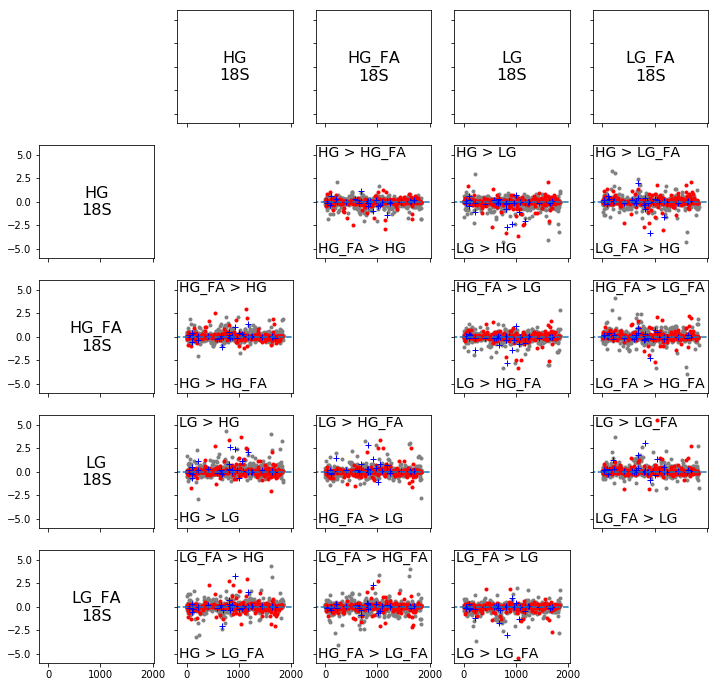

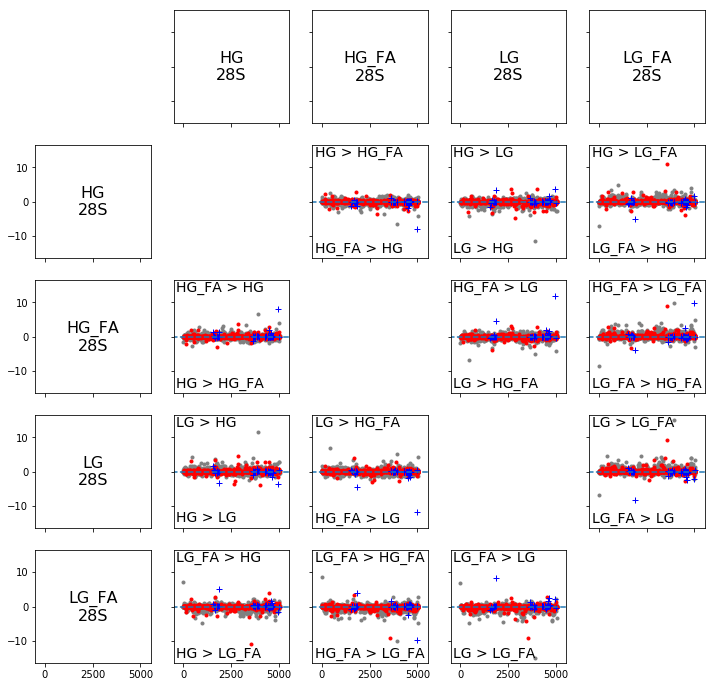

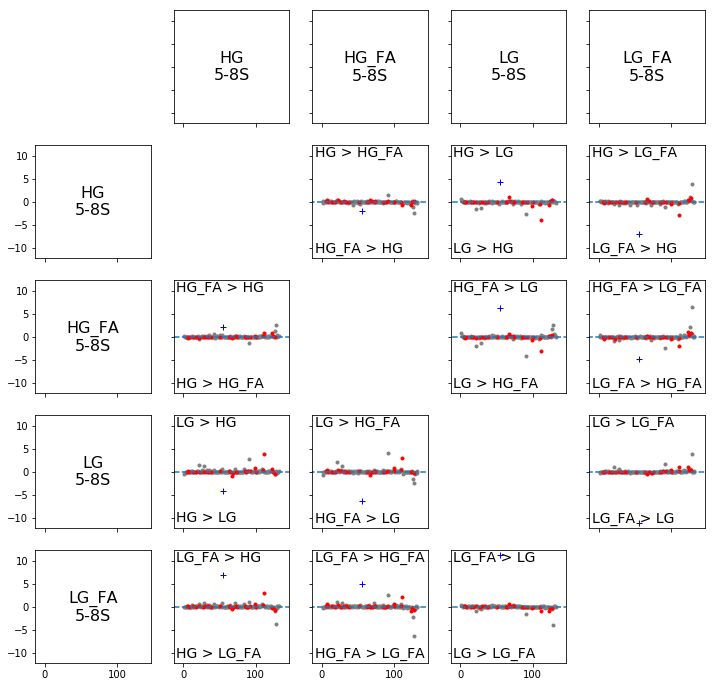

In [39]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    compare_exps(df, exp_peaks, ref_name, known_sites, window_size, output_folder, 
                         by_position=True, cutoff=None,log_scale=None,show_plot=True)